In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as çflt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)

2023-01-24 10:48:50.241571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-24 10:48:50.241588: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data augmentation

In [15]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=5,var1_u=15,CROP1=CROP,BATCH_SIZE=5)

In [16]:
xs, ys,zs = next(gen_batch_train.as_numpy_iterator())

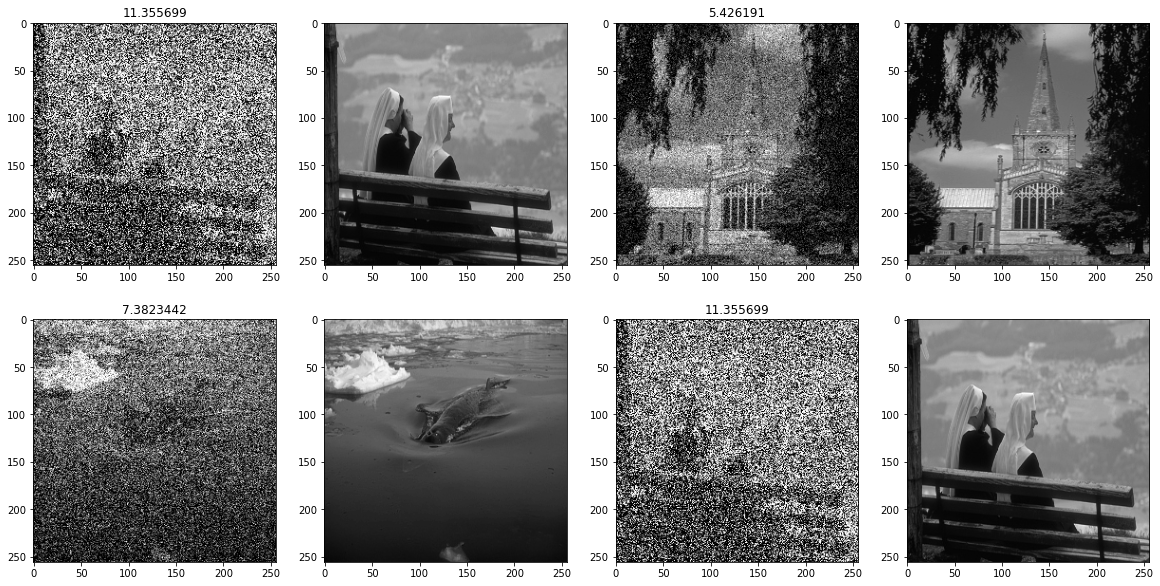

In [17]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j].set_title(str(zs[_][0]))
        
plt.show()

# Neural networks

In [18]:
#strategy = tf.distribute.MirroredStrategy()
strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

In [19]:
order = 1
num_classes = 20
model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='mse',)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 128, 128, 32  320         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_22 (BatchN  (None, 128, 128, 32  128        ['conv2d_12[0][0]']              
 ormalization)                  )                                                           

 Conv2D)                                                                                          
                                                                                                  
 batch_normalization_29 (BatchN  (None, 32, 32, 64)  256         ['separable_conv2d_23[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 16, 16, 64)  0           ['batch_normalization_29[0][0]'] 
 )                                                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 64)   2112        ['add_51[0][0]']                 
                                                                                                  
 add_52 (A

 tf.math.reduce_max_20 (TFOpLam  (None, 1)           0           ['norm_0[0][0]']                 
 bda)                                                                                             
                                                                                                  
 lambda_220 (Lambda)            (1, 21)              0           ['multiply_110[0][0]']           
                                                                                                  
 partition_0 (Multiply)         (None, 21)           0           ['tf.math.reduce_max_20[0][0]',  
                                                                  'lambda_220[0][0]']             
                                                                                                  
 dense_2 (Dense)                (None, 40)           41000       ['flatten_2[0][0]']              
                                                                                                  
 tf.__oper

                                                                                                  
 tf.cast_80 (TFOpLambda)        (None, 254, 254, 20  0           ['tf.math.logical_and_80[0][0]'] 
                                )                                                                 
                                                                                                  
 tf.cast_81 (TFOpLambda)        (None, 254, 254, 20  0           ['tf.math.logical_and_81[0][0]'] 
                                )                                                                 
                                                                                                  
 tf.cast_82 (TFOpLambda)        (None, 254, 254, 20  0           ['tf.math.logical_and_82[0][0]'] 
                                )                                                                 
                                                                                                  
 tf.cast_8

                                 (None, 254, 254),                                                
                                 (None, 254, 254),                                                
                                 (None, 254, 254),                                                
                                 (None, 254, 254)]                                                
                                                                                                  
 tf.unstack_11 (TFOpLambda)     [(None, 254, 254),   0           ['multiply_115[0][0]']           
                                 (None, 254, 254),                                                
                                 (None, 254, 254),                                                
                                 (None, 254, 254),                                                
                                 (None, 254, 254),                                                
          

                                                                  'tf.unstack_10[0][15]',         
                                                                  'tf.unstack_10[0][16]',         
                                                                  'tf.unstack_10[0][17]',         
                                                                  'tf.unstack_10[0][18]',         
                                                                  'tf.unstack_10[0][19]']         
                                                                                                  
 coeff_w_0 (Add)                (None, 254, 254)     0           ['tf.unstack_11[0][0]',          
                                                                  'tf.unstack_11[0][1]',          
                                                                  'tf.unstack_11[0][2]',          
                                                                  'tf.unstack_11[0][3]',          
          

 add_56 (Add)                   (None, 256, 256, 1)  0           ['tf.math.multiply_20[0][0]',    
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda_224 (Lambda)            (None, 256, 256, 1)  0           ['add_56[0][0]']                 
                                                                                                  
 lambda_225 (Lambda)            (None, 254, 254, 1)  0           ['lambda_224[0][0]']             
                                                                                                  
 lambda_226 (Lambda)            (None, 254, 254, 1)  0           ['lambda_224[0][0]']             
                                                                                                  
 lambda_227 (Lambda)            (None, 254, 254, 1)  0           ['lambda_224[0][0]']             
          

                                                                  'multiply_127[0][0]',           
                                                                  'multiply_128[0][0]',           
                                                                  'multiply_129[0][0]']           
                                                                                                  
 tf.zeros_like_44 (TFOpLambda)  (None, 254, 254, 1)  0           ['add_59[0][0]']                 
                                                                                                  
 tf.zeros_like_45 (TFOpLambda)  (None, 256, 256, 1)  0           ['lambda_234[0][0]']             
                                                                                                  
 tf.__operators__.getitem_90 (S  (None, 254, 1)      0           ['tf.zeros_like_44[0][0]']       
 licingOpLambda)                                                                                  
          

                                                                  'tf.expand_dims_227[0][0]']     
                                                                                                  
 tf.math.multiply_23 (TFOpLambd  (None, 256, 256, 1)  0          ['concatenate_47[0][0]']         
 a)                                                                                               
                                                                                                  
 add_62 (Add)                   (None, 256, 256, 1)  0           ['tf.math.multiply_23[0][0]',    
                                                                  'lambda_244[0][0]']             
                                                                                                  
 lambda_254 (Lambda)            (None, 256, 256, 1)  0           ['add_62[0][0]']                 
                                                                                                  
 lambda_25

                                                                                                  
 multiply_144 (Multiply)        (None, 254, 254, 1)  0           ['tf.expand_dims_198[0][0]',     
                                                                  'lambda_268[0][0]']             
                                                                                                  
 add_65 (Add)                   (None, 254, 254, 1)  0           ['multiply_141[0][0]',           
                                                                  'multiply_142[0][0]',           
                                                                  'multiply_143[0][0]',           
                                                                  'multiply_144[0][0]']           
                                                                                                  
 tf.zeros_like_50 (TFOpLambda)  (None, 254, 254, 1)  0           ['add_65[0][0]']                 
          

                                                                  'add_67[0][0]',                 
                                                                  'tf.expand_dims_253[0][0]']     
                                                                                                  
 concatenate_53 (Concatenate)   (None, 256, 256, 1)  0           ['tf.expand_dims_254[0][0]',     
                                                                  'concatenate_52[0][0]',         
                                                                  'tf.expand_dims_254[0][0]']     
                                                                                                  
 tf.math.multiply_26 (TFOpLambd  (None, 256, 256, 1)  0          ['concatenate_53[0][0]']         
 a)                                                                                               
                                                                                                  
 add_68 (A

 multiply_157 (Multiply)        (None, 254, 254, 1)  0           ['tf.expand_dims_196[0][0]',     
                                                                  'lambda_296[0][0]']             
                                                                                                  
 multiply_158 (Multiply)        (None, 254, 254, 1)  0           ['tf.expand_dims_197[0][0]',     
                                                                  'lambda_297[0][0]']             
                                                                                                  
 multiply_159 (Multiply)        (None, 254, 254, 1)  0           ['tf.expand_dims_198[0][0]',     
                                                                  'lambda_298[0][0]']             
                                                                                                  
 add_71 (Add)                   (None, 254, 254, 1)  0           ['multiply_156[0][0]',           
          

                                                                                                  
 tf.expand_dims_281 (TFOpLambda  (None, 1, 256, 1)   0           ['tf.__operators__.getitem_119[0]
 )                                                               [0]']                            
                                                                                                  
 concatenate_58 (Concatenate)   (None, 254, 256, 1)  0           ['tf.expand_dims_280[0][0]',     
                                                                  'add_73[0][0]',                 
                                                                  'tf.expand_dims_280[0][0]']     
                                                                                                  
 concatenate_59 (Concatenate)   (None, 256, 256, 1)  0           ['tf.expand_dims_281[0][0]',     
                                                                  'concatenate_58[0][0]',         
          

# Training

In [20]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/splines_{typ}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
]

In [21]:
history = model.fit(
        gen_batch_train,
        epochs=2,
        steps_per_epoch=10,
        validation_data=gen_batch_val,
        validation_steps=2,
        shuffle=False,
        use_multiprocessing=True,
        #callbacks=callbacks,
        workers=1
    )

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 1.4075

10/10 [==============================] - 27s 2s/step - loss: 1.4075 - val_loss: 0.9545
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 1.0662

10/10 [==============================] - 15s 2s/step - loss: 1.0662 - val_loss: 1.0004


# Results

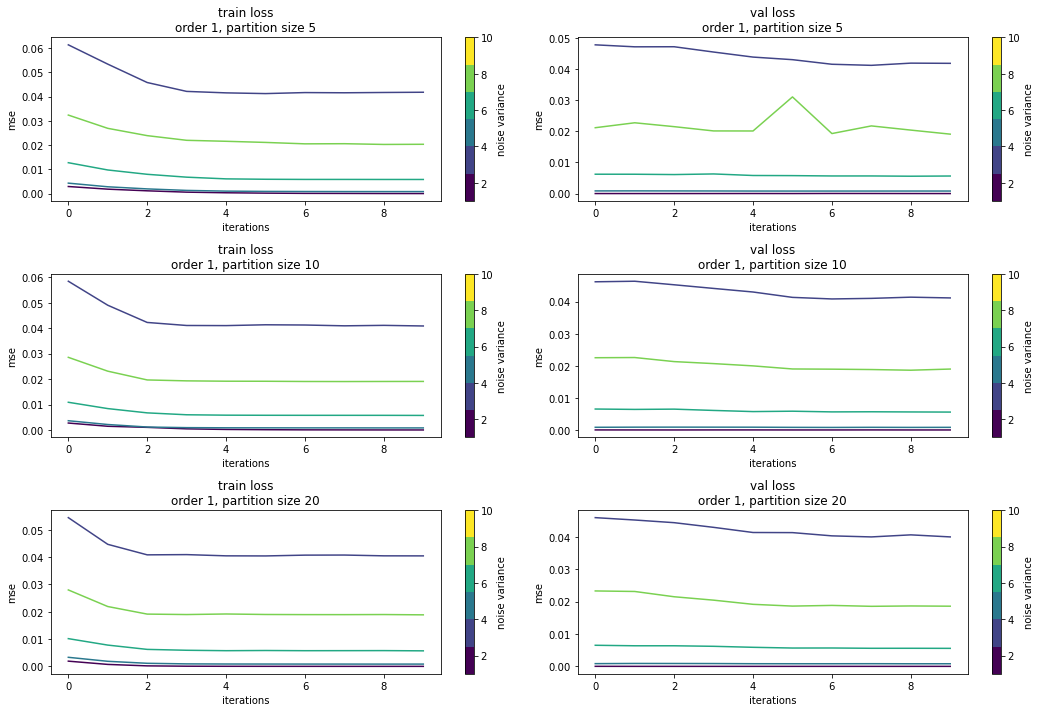

In [2]:
order = 1

classes = np.unique([int(i.split('_')[-2]) for i in glob(f'./history/splines_{typ}*_{order}.npy')])
classes = classes[:-1]
fig,axs = plt.subplots(nrows = len(classes),ncols=2,figsize=(15,10))

for k,num_classes in enumerate(classes):
    #num_classes = 20
    n = len(glob(f'./history/splines_{typ}*{num_classes}_{order}.npy'))+1
    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, n))
    newcmp = ListedColormap(colors)


    
    #w = np.arange(0.05,3,0.15)
    ylab = ['mse','mse']
    titles = ['train loss','val loss']
    ct = [tuple(i) for i in colors]

    trained = glob(f'./history/splines_{typ}*{num_classes}_{order}.npy')
    w = [float(i.split('_')[-3]) for i in trained]
    norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))
    for m,i in enumerate(trained):
        hist = np.load(i)
        #c = int(float(i.split('_')[-2])//0.15)
        c = m
        for j in range(len(hist)-1):

            if j%2 == 0:
                im = axs[k,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))
            else:
                im = axs[k,j].plot(np.array(hist[j]),color = colors[c],label=str(w[c]))

            axs[k,j].set_title(f'{titles[j]}\norder {order}, partition size {num_classes}')
            axs[k,j].set_xlabel('iterations')
            axs[k,j].set_ylabel(ylab[int(j%2)])


        
    
    
    for j in range(len(hist)-1):
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[k,j],label='noise variance')
        

plt.tight_layout()
plt.show()

# Results with first function

In [11]:
order = 1
num_classes = 50
model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)

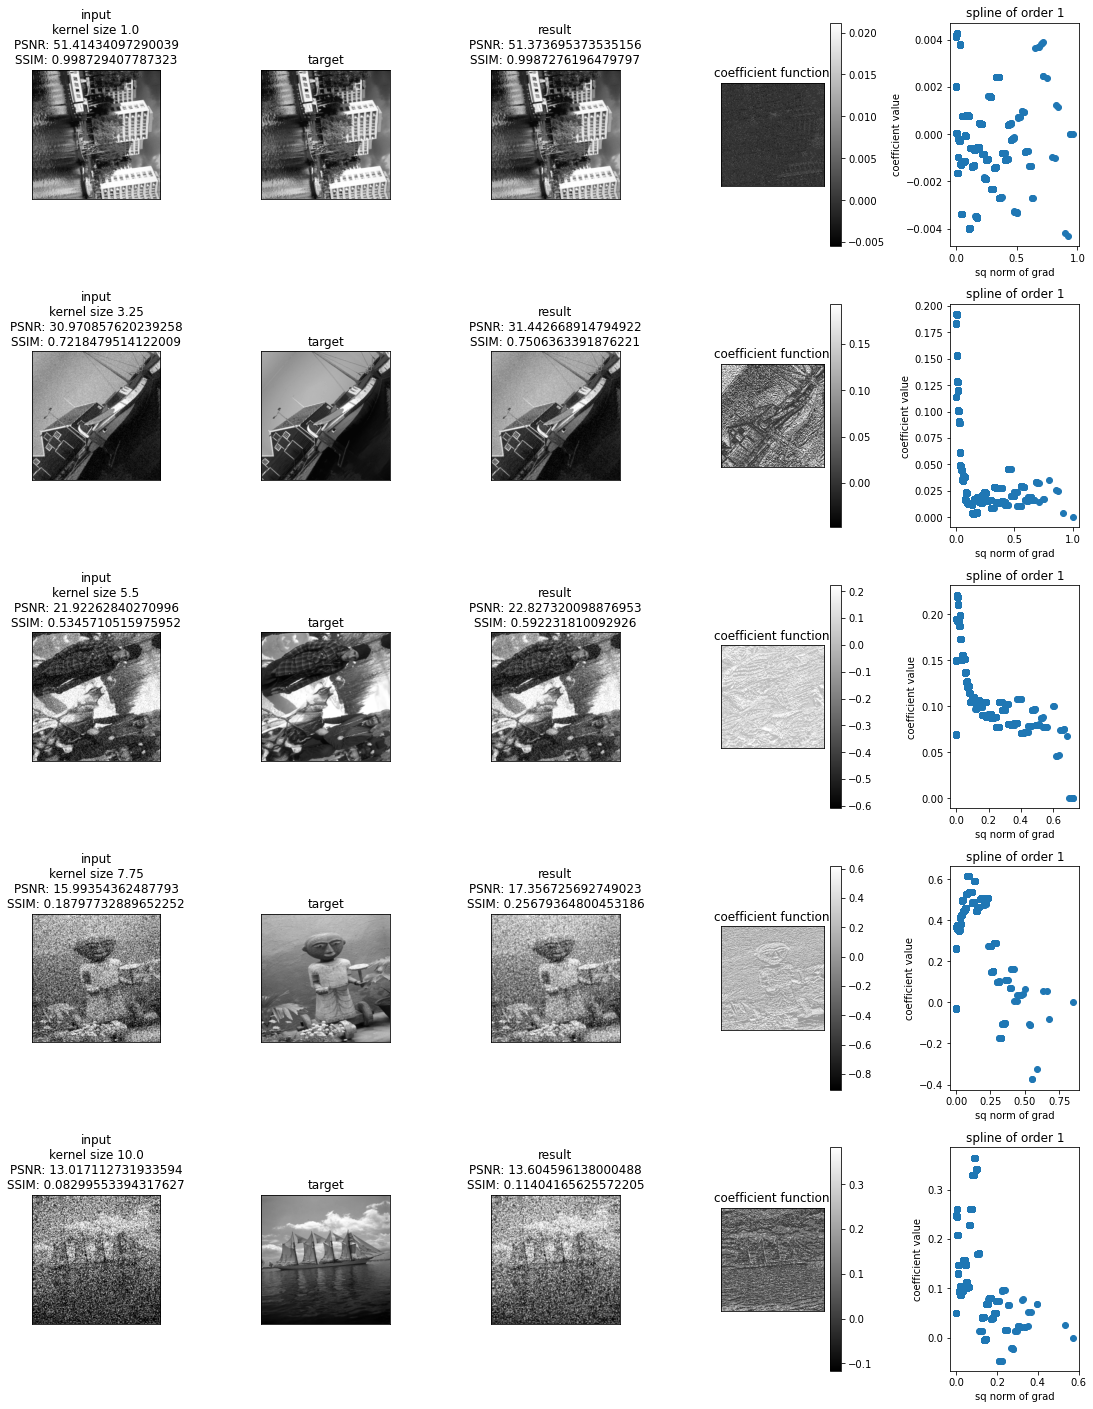

In [12]:


w = np.unique([float(i.split('_')[-3]) for i in glob(f'./checkpoints/splines_{typ}_*_{num_classes}_{order}*')])
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,20))
for i,m in enumerate(w):

    
    model.load_weights(f'./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}')
    #im = open_frame(val[_],var = w[i])
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    _ = np.random.choice(len(ims[0]))
    im = ims[:,_,...]
    im = np.asarray(im,dtype='float32')
    p = model(ims[0])
    
    #psnr_0 = tf.image.psnr(np.array([np.expand_dims(im[0],axis=-1)]),np.array([np.expand_dims(im[1],axis=-1)]),1)[0]
    #ssim_0 = tf.image.ssim(np.array([np.expand_dims(im[0],axis=-1)]),np.array([np.expand_dims(im[1],axis=-1)]),1)[0]
    psnr_0 = tf.image.psnr(np.array([im[0]]),np.array([im[1]]),1)[0]
    ssim_0 = tf.image.ssim(np.array([im[0]]),np.array([im[1]]),1)[0]
    clean = p[_]
    psnr = tf.image.psnr(np.array([im[1]]),clean,1)[0]
    ssim = tf.image.ssim(np.array([im[1]]),clean,1)[0]
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    visualization = tf.keras.models.Model(model.input,model.get_layer('coeff_x_0').output)
    vis = visualization(np.array([np.expand_dims(im[1],axis=-1)]))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline_0').output)
    spline = np.squeeze(get_lambdas(np.array([np.expand_dims(im[1],axis=-1)])))
    norm_layer = tf.keras.models.Model(model.input,model.get_layer('norm_0').output)
    norm = np.squeeze(norm_layer(np.array([np.expand_dims(im[1],axis=-1)])))
    partition_layer = tf.keras.models.Model(model.input,model.get_layer('partition_0').output)
    partition = np.squeeze(partition_layer(np.array([np.expand_dims(im[1],axis=-1)])))
    
    
    axs[i,0].imshow(im[0],cmap='gray')
    axs[i,0].set_title(f'input\nkernel size {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(im[1],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(np.squeeze(vis[0]),cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    N = np.ndarray.flatten(norm)
    loc = np.logical_and(N < np.expand_dims(partition[1:],axis=-1),N >= np.expand_dims(partition[:-1],axis=-1))
    power_norm = np.power(np.expand_dims(N,axis=-1),np.reshape(np.arange(order+1),(1,order+1)))
    coeff_plot = np.sum(np.multiply(np.expand_dims(loc.T,axis=-1),spline),axis=1)
    
    fc = np.sum(np.multiply(coeff_plot,power_norm),axis=-1)
    axs[i,4].scatter(N,fc)
    axs[i,4].set_xlabel("sq norm of grad")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline of order {order}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

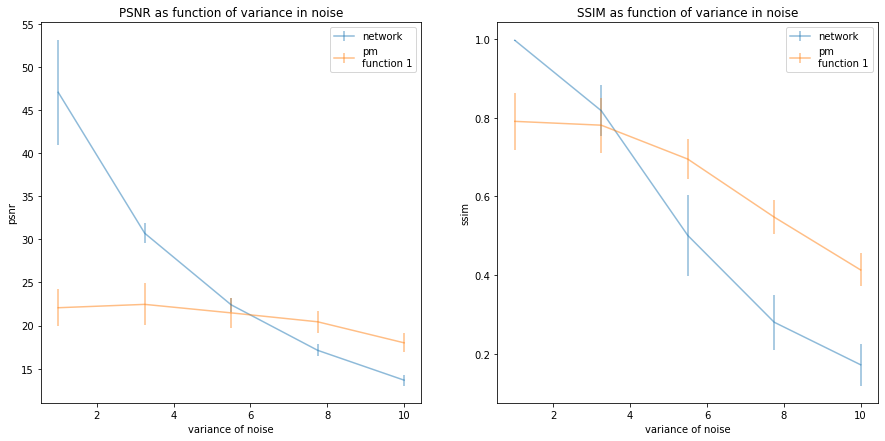

In [5]:
order = 1
num_classes = 50

trained = glob(f'./history/splines_{typ}*1.npy')
w = np.unique([float(i.split('_')[-3]) for i in trained])
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

for i,m in enumerate(w):
    model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
    model.load_weights(f"./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}")
    gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=100)
    ims = np.array(next(gen_batch_val.as_numpy_iterator()))
    
    res = model(ims[0])
    res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
    #psnr = tf.image.psnr(res,ims[1],1).numpy()
    #ssim = tf.image.ssim(res,ims[1],1).numpy()
    psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_nn_1.append(np.mean(psnr))
    psnr_nn_s_1.append(np.std(psnr))
    ssim_nn_1.append(np.mean(ssim))
    ssim_nn_s_1.append(np.std(ssim))
    
    pm = np.expand_dims([np.squeeze(anisodiff(im,niter=10,lambd=50,option=1)) for im in ims[0]],axis=-1)
    pm = np.asarray(pm,dtype='float32')
    psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_pm_1.append(np.mean(psnr))
    psnr_pm_s_1.append(np.std(psnr))
    ssim_pm_1.append(np.mean(ssim))
    ssim_pm_s_1.append(np.std(ssim))
    
    

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)

#plt.errorbar(w,psnr_nn_2,psnr_nn_s_2,label='network\nfunction 2',alpha=0.5)
#plt.errorbar(w,psnr_pm_2,psnr_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

In [6]:
order = 1
trained = glob(f'./history/splines_{typ}*1.npy')
w = np.unique([float(i.split('_')[-3]) for i in trained])
ncl = np.unique([int(i.split('_')[-2]) for i in trained])

hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]

    for i,m in enumerate(w):
        model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
        model.load_weights(f"./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}")
        gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=100)
        ims = np.array(next(gen_batch_val.as_numpy_iterator()))

        res = model(ims[0])
        res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
        psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_nn_1.append(np.mean(psnr))
        ssim_nn_1.append(np.mean(ssim))


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    
 

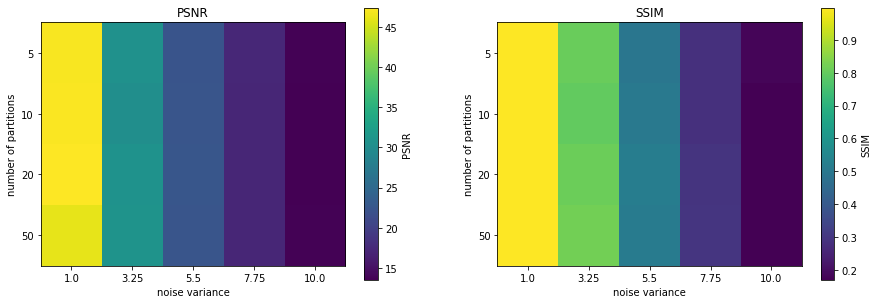

In [7]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [8]:
R = []
order = 1
trained = glob(f'./history/splines_{typ}*1.npy')
w = np.unique([float(i.split('_')[-3]) for i in trained])
ncl = np.unique([int(i.split('_')[-2]) for i in trained])

for num_classes in ncl:
    R.append([])
    model = get_model("splines",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
    
    for i,m in enumerate(tqdm(w)):

        
        model.load_weights(f"./checkpoints/splines_{typ}_{w[i]}_{num_classes}_{order}")
        
        temp_mean = [[] for c in range(num_classes)]
        gen_batch_train,gen_batch_val = get_generators(typ,w[i],CROP1=CROP,BATCH_SIZE=50)
        xs, ys = next(gen_batch_train.as_numpy_iterator())
        for _ in range(len(xs)):


            xs[_]
            get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline_0').output)
            spline = np.squeeze(get_lambdas(np.array([np.expand_dims(xs[_],axis=-1)])))
            norm_layer = tf.keras.models.Model(model.input,model.get_layer('norm_0').output)
            norm = np.squeeze(norm_layer(np.array([np.expand_dims(xs[_],axis=-1)])))
            partition_layer = tf.keras.models.Model(model.input,model.get_layer('partition_0').output)
            partition = np.squeeze(partition_layer(np.array([np.expand_dims(xs[_],axis=-1)])))
            #partition = np.amax(N)*partition/np.amax(partition)

            N = np.ndarray.flatten(norm)
            loc = np.logical_and(N < np.expand_dims(partition[1:],axis=-1),N >= np.expand_dims(partition[:-1],axis=-1))
            power_norm = np.power(np.expand_dims(N,axis=-1),np.reshape(np.arange(order+1),(1,order+1)))
            coeff_plot = np.sum(np.multiply(np.expand_dims(loc.T,axis=-1),spline),axis=1)

            fc = np.sum(np.multiply(coeff_plot,power_norm),axis=-1)

            classes = np.argmax(loc,axis = 0)
            for c in range(num_classes):
                temp_mean[c] = np.concatenate((temp_mean[c],fc[np.argmax(loc,axis=0) == c]))
                temp_mean[c] = np.nan_to_num(temp_mean[c])

        mean = [np.mean(j) for j in temp_mean]
        std = [np.std(j) for j in temp_mean]

        R[-1].append(np.transpose([mean,std]))

100%|█████████████████████████████████████████████| 5/5 [00:17<00:00,  3.46s/it]


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.63s/it]


100%|█████████████████████████████████████████████| 5/5 [00:22<00:00,  4.59s/it]


100%|█████████████████████████████████████████████| 5/5 [00:43<00:00,  8.63s/it]


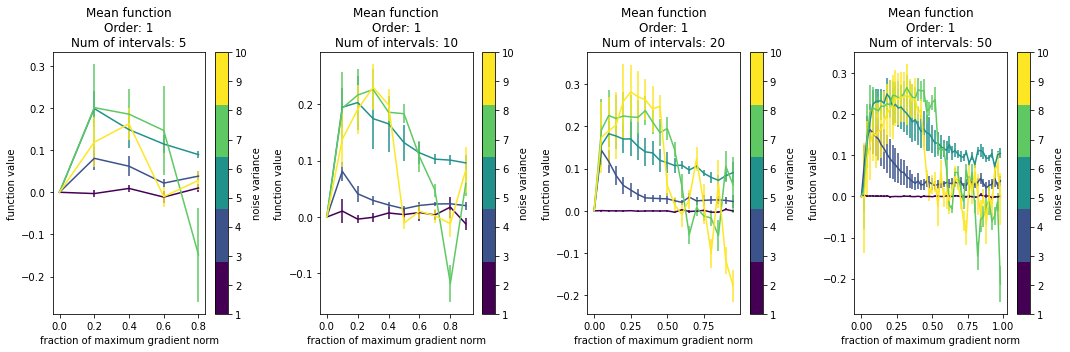

In [9]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = len(R),nrows = 1,figsize=(15,5))
orders,num_classes = [1,2,3,5],[5,10,20]

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        m,s = R[col][i].T

        axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])

    axs[col].set_title(f"Mean function\nOrder: {1}\nNum of intervals: {ncl[col]}")
    axs[col].set_xlabel("fraction of maximum gradient norm")
    axs[col].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col],label='noise variance')

plt.tight_layout()        
plt.show()